# <img align="right" src="../additional_data/banner.png" style="width:1100px;">

# Exporting cloud-optimised GeoTIFF files 

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the Open Data Cube implemention environments
* **Products used:** 
[s2_l2a](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a)


## Background

It can be useful to export data to a GeoTIFF, e.g. for further analysis in a GIS of your choice. 
A `Cloud Optimized GeoTIFF` (COG) is a regular GeoTIFF file aimed at being hosted on a HTTP file server, with an internal organization that enables more efficient workflows on the cloud.

## Description

This notebook shows a number of ways to export a GeoTIFF file using the `datacube.utils.cog` function `write_cog`:

1. Exporting a single-band, single time-slice GeoTIFF from an xarray object loaded through a `dc.load` query
2. Exporting a multi-band, single time-slice GeoTIFF from an xarray object loaded through a `dc.load` query
3. Exporting multiple GeoTIFFs, one for each time-slice of an xarray object loaded through a `dc.load` query

In addition, the notebook demonstrates several more advanced applications of `write_cog`:

1. Passing in custom `rasterio` parameters to override the function's defaults
2. Exporting data from lazily loaded dask arrays

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [ ]:
import sys
import rasterio
import datacube
from datacube.utils.cog import write_cog
# we load first a additional path where needed packages are located, e.g. 'DEAPlotting' with the function 'rgb'
sys.path.append('/datacube/data_cube_notebooks/datacube/Scripts')
from DEAPlotting import rgb

### Connect to the datacube

In [15]:
dc = datacube.Datacube(app='Exporting_GeoTIFFs', config = '/home/datacube/.datacube.conf')

## Load Sentinel-2 data from the datacube

Here we are loading in a timeseries of `Sentinel-2` satellite images through the datacube API. E.g. scenes collected in the Gutenberg forest near Wuerzburg (official coordinate system ['EPSG:25832'](https://www.ldbv.bayern.de/file/pdf/12867/Faltblatt_UTM-Umstellung.pdf))

In [16]:
# Create query variables
product = 's2_l2a_bavaria'
x_min = 560000
x_max = 566000
y_min = 5505000
y_max = 5511000
cosy = 'EPSG:25832'
time_extent = ('2015-01-01', '2015-12-31')

In [17]:
# Load data
dataset = dc.load(product=product,
                  y= (y_min, y_max),
                  x=(x_min, x_max),
                  crs=cosy,
                  time=time_extent,
                 measurements=['blue','green','red'])
# Print output data
dataset

<xarray.Dataset>
Dimensions:      (time: 21, x: 600, y: 600)
Coordinates:
  * time         (time) datetime64[ns] 2015-07-30T10:30:16 ... 2015-12-27T10:...
  * y            (y) float64 5.511e+06 5.511e+06 ... 5.505e+06 5.505e+06
  * x            (x) float64 5.6e+05 5.6e+05 5.6e+05 ... 5.66e+05 5.66e+05
    spatial_ref  int32 25832
Data variables:
    blue         (time, y, x) int16 822 731 598 569 612 ... 1798 1768 1850 1825
    green        (time, y, x) int16 904 829 818 819 834 ... 1965 1944 2040 1943
    red          (time, y, x) int16 669 678 776 795 744 ... 1931 1954 1858 1852
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

### Plot an rgb image to confirm we have data

White regions are most probably cloud cover. The 'time' dimension above shows the number of observations and is also the range that can be choosen, considering that Python starst counting with `0`.

***
#### **Excourse**
You can plot a single observation using `index=[1]` in `rgb()` for the first observation in the time series. Or you can plot all `n` (this can take long, depending on the lenght of the time-series), using the `range()` function `([i for i in range(0, n, 1)])`.
#### **Excourse**
***

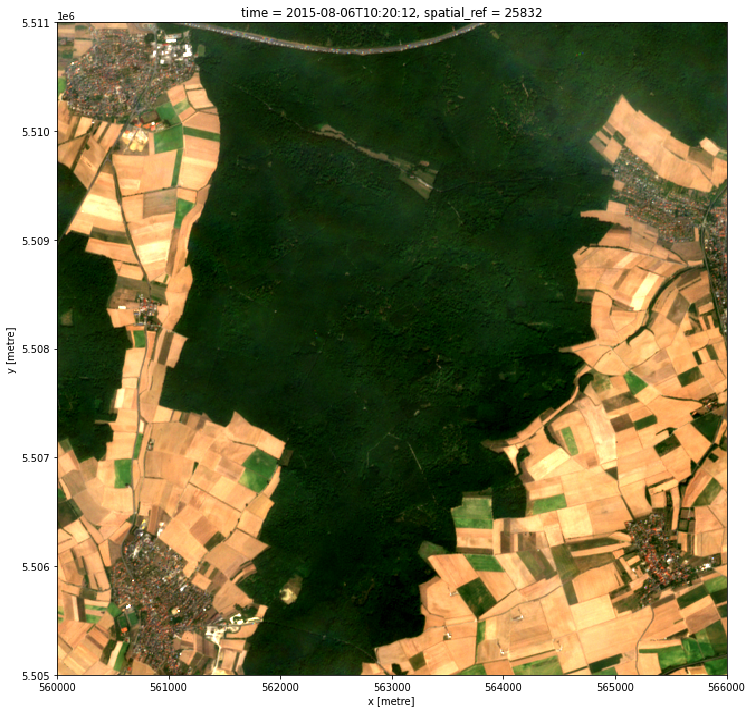

In [18]:
rgb(dataset, index=[1], percentile_stretch=(0.05, 0.95), size=12)
# A direct export as png can be peformed using following statement in the rgb() function:
#      -> savefig_path='picture.png'

## Export GeoTIFFs
### Single-band, single time-slice data

This method uses the `datacube.utils.cog` function `write_cog` (where COG stands for [Cloud Optimised GeoTIFF](https://www.cogeo.org/)) to export a simple single-band, single time-slice GeoTIFF file.
A few important caveats should be noted when using this function:

1. It requires an `xarray.DataArray`; supplying an `xarray.Dataset` will return an error. To convert an `xarray.Dataset` to an `xarray.DataArray` run the following:

```
dataset = dataset.to_array()
```

2. This function generates a temporary in-memory GeoTIFF file without compression. 
This means the function will temporarily use about 1.5 to 2 times the memory of the input `xarray.DataArray`

3. The GeoTIFF can be downloaded for further analyzes in a GIS. When only the filename is given (e.g. `red_band.tif`), the file will be saved first in the same directory the notebook is located

In [19]:
# Select a single time-slice and a single band from the dataset.
singleband_da = dataset.red.isel(time=1)

# Write GeoTIFF to a location
write_cog(geo_im=singleband_da,
          fname='red001.tif',
          overwrite=True)

PosixPath('red001.tif')

### Multi-band, single time-slice data

Here we select a single time and export all the bands in the dataset using `write_cog`. The produced file probably cant be shown in the browser but your GIS should do this.

In [20]:
# Select a single time-slice
rgb_da = dataset.isel(time=1).to_array()

# Write multi-band GeoTIFF to a location
write_cog(geo_im=rgb_da,
          fname='rgb_plus.tif',
          # Add a custom folder:
          # fname=
          overwrite=True)

PosixPath('rgb_plus.tif')

### Multi-band, multiple time-slice data

If we want to export all of the time steps in a dataset, we can wrap `write_cog` in a for-loop and export each time slice as an individual GeoTIFF file:

In [13]:
for i in range(len(dataset.time)):

    # We will use the date of the satellite image to name the GeoTIFF
    date = dataset.isel(time=i).time.dt.strftime('%Y-%m-%d').data
    print(f'Writing {date}')
    
    # Convert current time step into a `xarray.DataArray`
    singletimestamp_da = dataset.isel(time=i).to_array()

    # Write GeoTIFF  
    write_cog(geo_im=singletimestamp_da,
              fname=f'{date}.tif',
              overwrite=True)

Writing 2020-03-02
Writing 2020-03-05
Writing 2020-03-07
Writing 2020-03-10
Writing 2020-03-12
Writing 2020-03-15
Writing 2020-03-17
Writing 2020-03-17
Writing 2020-03-20
Writing 2020-03-22
Writing 2020-03-25
Writing 2020-03-27
Writing 2020-03-30
Writing 2020-04-01


## Advanced

### Passing custom `rasterio` parameters
By default, `write_cog` will read attributes like `nodata` directly from the attributes of the data itself.
However, `write_cog` also accepts any parameters that could be passed to the underlying [`rasterio.open`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html) function, so these can be used to override the default attribute values.

For example, it can be useful to provide a new `nodata` value, for instance if data is transformed to a different `dtype` or scale and the original `nodata` value is no longer appropriate.
By default, `write_cog` will use a `nodata` value of `-999` as this is what is stored in the dataset's attributes:

In [8]:
# Select a single time-slice and a single band from the dataset.
singleband_da = dataset.red.isel(time=0)

# Print nodata attribute value
print(singleband_da.nodata)

-999


To override this value and use a `nodata` value of 0 instead:

In [23]:
# Write GeoTIFF  
write_cog(geo_im=singleband_da,
          fname='new_nodata_value.tif',
          overwrite=True,
          nodata=0.0)

PosixPath('new_nodata_value.tif')

We can verify the nodata value is now set to `0.0` by reading the data back in with `rasterio`:

In [24]:
with rasterio.open('new_nodata_value.tif') as geotiff:
    print(geotiff.nodata)

0.0


#### Unsetting nodata for `float` datatypes containing `NaN`
A common analysis workflow is to load data from the datacube, then mask out certain values by setting them to `NaN`.
For example, we may use the `.where()` method to set all -999 `nodata` values in our data to `NaN`:

> **Note:** The `mask_invalid_data` function from `datacube.utils.masking` can also be used to automatically set `nodata` values from the data's attributes to `NaN`.
This function will also automatically drop the `nodata` attribute from the data, removing the need for the steps below.
For more information, see the [Masking data notebook](Masking_data.ipynb).


In [11]:
# Select a single time-slice and a single band from the dataset.
singleband_da = dataset.red.isel(time=0)

# Set -999 values to NaN
singleband_masked = singleband_da.where(singleband_da != -999)
print(singleband_masked)

<xarray.DataArray 'nbart_red' (y: 212, x: 191)>
array([[ 411.,  422.,  404., ...,  933.,  670.,  544.],
       [ 533.,  539.,  530., ...,  812.,  666.,  751.],
       [ 567.,  609.,  788., ...,  907.,  840.,  829.],
       ...,
       [ 269.,  308.,  412., ...,  319.,  306.,  314.],
       [ 278.,  286.,  428., ...,  321.,  322.,  326.],
       [ 304.,  560., 1339., ...,  332.,  322.,  312.]])
Coordinates:
    time         datetime64[ns] 2018-01-03T23:42:39.393181
  * y            (y) float64 -3.307e+06 -3.307e+06 ... -3.313e+06 -3.313e+06
  * x            (x) float64 2.053e+06 2.053e+06 ... 2.058e+06 2.058e+06
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        -999
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


In this case, since we have replaced -999 `nodata` values with `NaN`, the data's `nodata` attribute is no longer valid. 
Before we write our data to file, we should therefore remove the `nodata` attribute from our data:

In [12]:
# Remove nodata attribute
singleband_masked.attrs.pop('nodata') 

# Write GeoTIFF
write_cog(geo_im=singleband_masked,
          fname='masked_data.tif',
          overwrite=True)

PosixPath('masked_data.tif')

If we read this GeoTIFF back in with `rasterio`, we will see that it no longer has a `nodata` attribute set:

In [13]:
with rasterio.open('masked_data.tif') as geotiff:
    print(geotiff.nodata)

None


### Exporting GeoTIFFs from a `dask` array

> **Note:** For more information on using `dask`, refer to the [Parallel processing with Dask notebook](../Beginners_guide/07_Parallel_processing_with_Dask.ipynb)

If you pass a lazily-loaded dask array into the function, `write_cog` will not immediately output a GeoTIFF, but will instead return a `dask.delayed` object:

In [14]:
# Lazily load data using dask
ds_dask = dc.load(product='ga_ls8c_ard_3', 
                  dask_chunks={},
                  **query)

# Run `write_cog`
ds_delayed = write_cog(geo_im=ds_dask.isel(time=0).to_array(), 
                       fname='dask_geotiff.tif',
                       overwrite=True)

# Print dask.delayed object
print(ds_delayed)

Delayed('_write_cog-6da1c71e-9990-4cf5-aac9-8146108da04e')


To trigger the GeoTIFF to be exported to file, run `.compute()` on the `dask.delayed` object.
The file will now appear in the file browser to the left.

In [15]:
ds_delayed.compute()

PosixPath('dask_geotiff.tif')

***
## Additional information

<font size="2">This notebook for the usage in the Open Data Cube entities of the [Department of Remote Sensing](http://remote-sensing.org/), [University of Wuerzburg](https://www.uni-wuerzburg.de/startseite/), is adapted from [Geoscience Australia](https://github.com/GeoscienceAustralia/dea-notebooks), published using the Apache License, Version 2.0. Thanks! </font>

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.


**Contact:** If you would like to report an issue with this notebook, you can file one on [Github](https://github.com).

**Last modified:** December 2020